In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from dgl.nn import GraphConv,MaxPooling
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os

%matplotlib inline

/home/echigo/anaconda3/envs/DGL2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#トレーニング用データセットクラス
class CIFAR10TrainDataset(DGLDataset):
    def __init__(self,data_path,transform = False,mean=None,std = None):
        self.data_path = data_path
        self.transform = transform
        self.mean = mean
        self.std = std
        eps = 10**-9
        super().__init__(name='cifar10_train__gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入

    def __getitem__(self, idx):
        if self.transform == True:
            data = self.graphs[idx].ndata['feat value']
            if self.mean is None:
                mean = torch.mean(data,dim=0)
            else:
                mean = self.mean
            if self.std is None:
                std = torch.std(data,dim=0,unbiased=False)
            else:
                std = self.std
            data = (data - mean) / std
            self.graphs[idx].ndata['feat value'] = data

        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


class CIFAR10TestDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='cifar10_test_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)



In [4]:
transform = transforms.Compose([transforms.Normalize(0,1)])
traindataset = CIFAR10TrainDataset("./data/NewMyData/train_dist_50_full.dgl")
testdataset = CIFAR10TestDataset("./data/NewMyData/test_dist_50_full.dgl")

In [5]:
if os.name =='posix':
    num_workers = 2
else:
    num_workers = 0
num_workers = 0
traindataloader = GraphDataLoader(traindataset,batch_size = 1000,shuffle = True,num_workers = num_workers,pin_memory = True)
testdataloader = GraphDataLoader(testdataset,batch_size = 5000,shuffle = True,num_workers = num_workers,pin_memory = True)
print(f'num_wokers = {num_workers}')
print(os.name)

num_wokers = 0
posix


In [4]:
print(traindataset[0][0].ndata['feat value'].shape)
for i in range(5):
    print(traindataset[3][0].ndata['feat value'][i])
print(traindataset[9][0].ndata['feat value'])
print(traindataset)

torch.Size([40, 40])
tensor([0.0000, 0.5225, 0.8200, 0.4449, 0.8137, 0.4253, 0.6610, 0.1168, 0.7684,
        0.3695, 0.5542, 0.7617, 0.4710, 0.2479, 0.4131, 0.0826, 0.7794, 0.7946,
        0.1306, 0.3554, 0.6453, 0.4991, 0.6210, 0.0584, 0.1652, 0.1847, 0.1306,
        0.5958, 0.5842, 0.4131, 0.0826, 0.4253, 0.2613, 0.2106, 0.5511, 0.4710,
        0.5871, 0.4817, 0.5386, 0.5290])
tensor([0.5225, 0.0000, 0.7131, 0.0826, 0.5542, 0.3919, 0.2337, 0.4213, 0.6319,
        0.1652, 0.0826, 0.6661, 0.4710, 0.5026, 0.4449, 0.4449, 0.6015, 0.5754,
        0.5386, 0.2106, 0.2479, 0.0584, 0.1753, 0.4710, 0.4957, 0.4131, 0.4563,
        0.1652, 0.1168, 0.1847, 0.5026, 0.1306, 0.4213, 0.4563, 0.0584, 0.1753,
        0.2106, 0.1168, 0.1306, 0.1847])
tensor([0.8200, 0.7131, 0.0000, 0.7320, 0.2409, 0.4131, 0.5386, 0.8200, 0.0826,
        0.7595, 0.7946, 0.0584, 0.3505, 1.0000, 0.4089, 0.7595, 0.1306, 0.1847,
        0.9347, 0.8137, 0.9582, 0.7617, 0.5783, 0.8179, 0.9366, 0.8841, 0.8783,
        0.8763, 0

In [5]:
#ネットワーク設定
class GCN(nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        self.conv1 = GraphConv(40,16)
        self.conv2 = GraphConv(16,32)
        self.conv3 = GraphConv(32,128)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.4)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.conv2(g,h,None,e_feat)
        #h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')
        #return dgl.softmax_nodes(g,'h')

In [11]:
#ネットワーク設定
class GCNv2(nn.Module):
    def __init__(self):
        super(GCNv2,self).__init__()
        self.conv1 = GraphConv(30,60)
        self.conv2 = GraphConv(60,80)
        self.conv3 = GraphConv(80,10)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.5)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(50,40)
        self.fc2 = nn.Linear(40,30)
        self.fc3 = nn.Linear(30,10)
        self.fc4 = nn.Linear(20,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        '''
        h = self.maxpooling(h)

        #h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        #h = F.relu(self.fc3(h))
        h = self.fc3(h)
        #h = self.fc4(h)
        '''



        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')
        #return dgl.softmax_nodes(g,'h')

In [7]:
#ネットワーク設定
class GCNv3(nn.Module):
    def __init__(self):
        super(GCNv3,self).__init__()
        self.conv1 = GraphConv(40,60)
        self.conv2 = GraphConv(60,100)
        self.conv3 = GraphConv(100,120)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.5)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = MaxPooling()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(120,60)
        self.fc2 = nn.Linear(60,60)
        self.fc3 = nn.Linear(60,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(g,h)

        #h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        #g.ndata['h'] = h

        return h
        #return dgl.softmax_nodes(g,'h')

In [8]:
#ネットワーク設定
class GCNv4(nn.Module):
    def __init__(self):
        super(GCNv4,self).__init__()
        self.conv1 = GraphConv(20,60)
        self.conv2 = GraphConv(60,100)
        self.conv3 = GraphConv(100,120)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.5)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(60,60)
        self.fc2 = nn.Linear(60,60)
        self.fc3 = nn.Linear(60,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        #return h
        #return dgl.softmax_nodes(g,'h')
        return dgl.mean_nodes(g,'h')

In [23]:
#ネットワーク設定
class GCNv5(nn.Module):
    def __init__(self):
        super(GCNv5,self).__init__()
        self.conv1 = GraphConv(30,60)
        self.conv2 = GraphConv(60,100)
        self.conv3 = GraphConv(100,120)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.5)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(60,60)
        self.fc2 = nn.Linear(60,60)
        self.fc3 = nn.Linear(60,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        #return h
        #return dgl.softmax_nodes(g,'h')
        return dgl.mean_nodes(g,'h')

In [5]:
#ネットワーク設定
class GCNv6(nn.Module):
    def __init__(self):
        super(GCNv6,self).__init__()
        self.conv1 = GraphConv(40,80)
        self.conv2 = GraphConv(80,100)
        self.conv3 = GraphConv(100,120)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.5)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(60,60)
        self.fc2 = nn.Linear(60,60)
        self.fc3 = nn.Linear(60,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        #return h
        #return dgl.softmax_nodes(g,'h')
        return dgl.mean_nodes(g,'h')

In [6]:
#ネットワーク設定
class GCNv7(nn.Module):
    def __init__(self):
        super(GCNv7,self).__init__()
        self.conv1 = GraphConv(50,60)
        self.conv2 = GraphConv(60,80)
        self.conv3 = GraphConv(80,100)
        self.conv4 = GraphConv(100,128)
        self.dropout =nn.Dropout(0.2)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(50,40)
        self.fc2 = nn.Linear(40,30)
        self.fc3 = nn.Linear(30,20)
        self.fc4 = nn.Linear(20,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)
        #h = self.dropout(h)
        #h = self.conv4(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        #return h
        #return dgl.softmax_nodes(g,'h')
        return dgl.mean_nodes(g,'h')

In [8]:
# 16 32 64 128 x4 '''

In [ ]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.008)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 20

In [12]:
model = GCNv2()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 20

In [22]:
model = GCNv3()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.001)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 100

In [9]:
model = GCNv4()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 4000

In [24]:
model = GCNv5()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 4000

In [10]:
model = GCNv6()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 4000

In [7]:
model = GCNv7()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.003)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 4

In [8]:
save_train_acc = []
save_test_acc = []

In [9]:
loss_list = []
acc_list = []
test_acc_list = []


num_correct = 0
num_tests = 0
test_num_correct = 0
test_num_tests = 0
lossF = nn.CrossEntropyLoss()
#,batched_graph.edata['distance'].float()
BP = 0
for epoch in tqdm(range(epochs)):
    if BP != 0:
        break
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat value'].float())
        loss = lossF(pred,labels)
        if loss.item() < 0.05:
            BP = 0
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    loss_list.append(loss.item())
    acc_list.append(num_correct / num_tests) #学習中トレーニングacc
    
    model.eval()
    for tbatched_graph, tlabels in testdataloader:
        tbatched_graph = tbatched_graph.to(device)
        tlabels = tlabels.to(device)
        tpred = model(tbatched_graph, tbatched_graph.ndata['feat value'])
        test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
        test_num_tests += len(tlabels)

    Tacc = test_num_correct / test_num_tests
    #print('Training accuracy:', Tacc)
    test_acc_list.append(Tacc) #学習中テストacc


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


In [10]:

num_correct = 0
num_tests = 0



with torch.no_grad():
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat value'])
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Training accuracy:', num_correct / num_tests)
    save_train_acc.append(num_correct / num_tests)
    num_correct = 0
    num_tests = 0
    model.eval()
    for batched_graph, labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat value'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Test accuracy:', num_correct / num_tests)
    save_test_acc.append(num_correct / num_tests)

Training accuracy: 0.11645
Test accuracy: 0.1206


In [28]:
#5:40
#3:15
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(loss)
print(max(test_acc_list))

True
1
tensor(2.2911, device='cuda:0', grad_fn=<NllLossBackward0>)
0.114428


In [14]:
ksk = np.load('node_30_loss_trainacc_testacc.npy')

In [15]:
print(len(ksk))

3


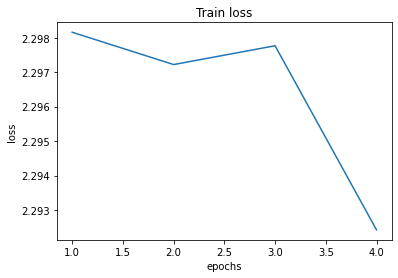

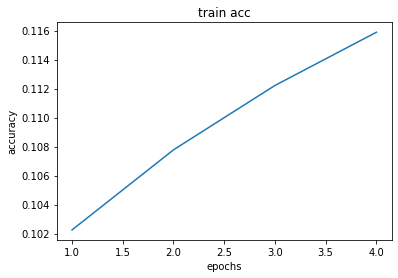

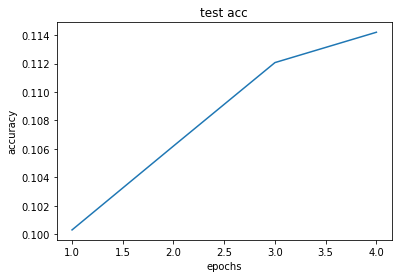

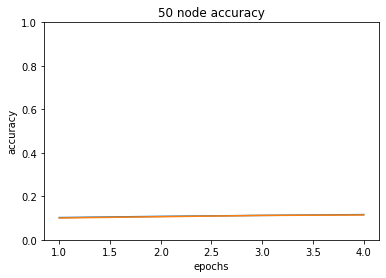

In [11]:
x = [p for p in range(1,len(loss_list)+1)]
y = loss_list


plt.plot(x,y)
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


plt.plot(x,acc_list)
plt.title('train acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()


plt.plot(x,test_acc_list)
plt.title('test acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()


plt.plot(x,acc_list)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.title('50 node accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

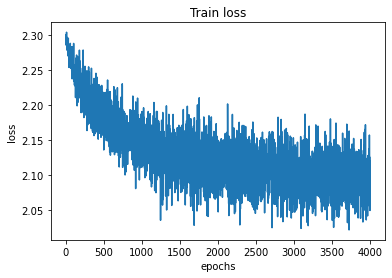

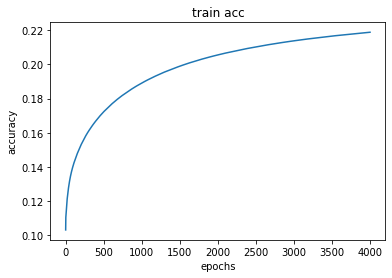

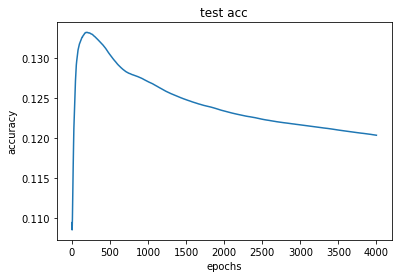

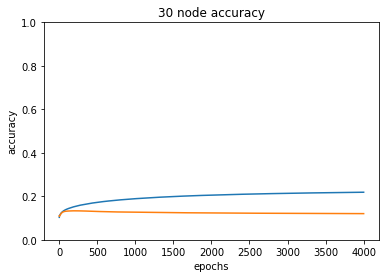

In [17]:
x = [p for p in range(1,len(loss_list)+1)]
y = loss_list


plt.plot(x,ksk[0])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


plt.plot(x,ksk[1])
plt.title('train acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()


plt.plot(x,ksk[2])
plt.title('test acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()


plt.plot(x,ksk[1])
plt.plot(x,ksk[2])
plt.ylim(0,1)
plt.title('30 node accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

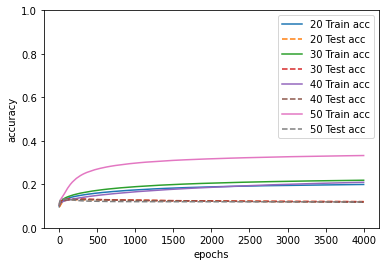

In [24]:
n20 = np.load('node_20_loss_trainacc_testacc.npy')
n30 = np.load('node_30_loss_trainacc_testacc.npy')
n40 = np.load('node_40_loss_trainacc_testacc.npy')
n50 = np.load('node_50_loss_trainacc_testacc.npy')
plt.plot(x,n20[1],label = '20 Train acc')
plt.plot(x,n20[2],label = '20 Test acc',linestyle = '--')
plt.plot(x,n30[1],label = '30 Train acc')
plt.plot(x,n30[2],label = '30 Test acc',linestyle = '--')
plt.plot(x,n40[1],label = '40 Train acc')
plt.plot(x,n40[2],label = '40 Test acc',linestyle = '--')
plt.plot(x,n50[1],label = '50 Train acc')
plt.plot(x,n50[2],label = '50 Test acc',linestyle = '--')
plt.legend()
plt.ylim(0,1)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [19]:
save_model_path = '20m4_4000epoch.pth'
torch.save(model.state_dict(),save_model_path)

In [11]:
print(type(loss_list))
print(save_train_acc)
print(save_test_acc)


<class 'list'>
[0.3582]
[0.1153]


In [12]:

node_40=[]
node_40.append(loss_list)
node_40.append(acc_list)
node_40.append(test_acc_list)
print(len(node_40))

3


In [13]:
np.save(file='node_50_loss_trainacc_testacc',arr=node_40)

In [ ]:
x = [p for p in range(1,len(loss_list)+1)]
y1 = acc_list
y2 = test_acc_list
plt.ylim(0,1)
'''
#20
plt.plot(x,train_acc_lists[0],label = '20 Train acc', color = "crimson")
plt.plot(x,test_acc_lists[0],label = '20 Test acc', color = "crimson",linestyle = 'dashed')

#30
plt.plot(x,train_acc_lists[1],label = '30 Train acc', color = "darkblue")
plt.plot(x,test_acc_lists[1],label = '30 Test acc', color = "darkblue",linestyle = 'dashed')

#40
plt.plot(x,train_acc_lists[2],label = '40 Train acc', color = "green")
plt.plot(x,test_acc_lists[2],label = '40 Test acc', color = "green",linestyle = 'dashed')
'''
plt.plot(x,y1,label='train acc')
plt.plot(x,y2,label='test acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and Test accuracy')
plt.legend()
plt.show()

In [35]:
print(save_train_acc)
print(save_test_acc)

[0.4065, 0.4174, 0.4706, 0.412, 0.4171, 0.41573333333333334, 0.41586666666666666, 0.4169333333333333, 0.4116666666666667, 0.41386666666666666, 0.4119, 0.4167, 0.4145, 0.4161666666666667, 0.4157666666666667, 0.4141]
[0.3377, 0.3246, 0.2941, 0.3054, 0.2995, 0.298, 0.3004, 0.3012, 0.2941, 0.2941, 0.3006, 0.2993, 0.3011, 0.2949, 0.3034, 0.2941]


In [ ]:
def f(x):
    return x*x-2

In [ ]:
from torch.autograd import Variable

In [ ]:
ini_x_value = 5
ini_x_tensor = ini_x_value*torch.ones(1, 1, dtype = torch.float64)
x = Variable(ini_x_tensor, requires_grad=True)
print(f'roop {0:<4d} x = {x.item()}')

roop = 0
while roop < 10:
    roop += 1
    # 勾配の計算
    f(x).backward()
    # xの更新
    x.data -= (f(x)/x.grad).data
    # 勾配を0に設定
    x.grad.zero_()
    print(f'roop {roop:<4d} x = {x.item()}')

### 必要なもの
lossの履歴  
trainのacc  
testのacc  
実行時間

In [ ]:
loss_logs = []
train_acc_logs = []
test_acc_logs = []
run_time_logs = []

In [ ]:
#8-16-32-64-128-128-64-32-16-10
#8-64-512-512-64-10
#8-96-1152-1152-500-150-20-10


In [ ]:
#ネットワーク設定
class GCN1(nn.Module):
    def __init__(self):
        super(GCN1,self).__init__()
        self.conv1 = GraphConv(8,64)
        self.conv2 = GraphConv(64,512)
    
        self.flatten = nn.Flatten()

        self.liner1 = torch.nn.Linear(512,64)
        self.liner2 = torch.nn.Linear(64,10)

        self.dropout = torch.nn.Dropout(p = 0.2)

    def forward(self,g,n_feat,e_feat = None):
        h = F.relu(self.conv1(g,n_feat,None,e_feat))
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        
        h = self.flatten(h)

        h = F.relu(self.liner1(h))
        h = self.dropout(h)
        h = self.liner2(h)
        
        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')

In [ ]:
#ネットワーク設定
class GCN2(nn.Module):
    def __init__(self):
        super(GCN2,self).__init__()
        self.conv1 = GraphConv(8,96)
        self.conv2 = GraphConv(96,1152)
        
        self.flatten = nn.Flatten()
        
        self.liner1 = torch.nn.Linear(1152,500)
        self.liner2 = torch.nn.Linear(500,150)
        self.liner3 = torch.nn.Linear(150,20)
        self.liner4 = torch.nn.Linear(20,10)
        self.dropout = torch.nn.Dropout(p = 0.2)

    def forward(self,g,n_feat,e_feat = None):
        h = F.relu(self.conv1(g,n_feat,None,e_feat))
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        
        h = self.flatten(h)

        h = F.relu(self.liner1(h))
        h = self.dropout(h)
        h = F.relu(self.liner2(h))
        h = self.dropout(h)
        h = self.liner3(h)
        
        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_list = []
opt_list = []
model1 = GCN1()
model_list.append(model1)
model2 = GCN2()
model_list.append(model2)
model1.to(device)
model2.to(device)
optimizer1 = optim.Adam(model1.parameters(),lr = 0.01)
opt_list.append(optimizer1)
optimizer2 = optim.Adam(model2.parameters(),lr = 0.01)
opt_list.append(optimizer2)
epochs = 10

In [ ]:
for i in range(len(model_list)):
    loss_list = []
    acc_list = []

    num_correct = 0
    num_tests = 0
    start = time.time()
    runmodel = model_list[i]
    opt = opt_list[i]
    runmodel.train()
    for epoch in tqdm(range(epochs)):
        for batched_graph,labels in traindataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = runmodel(batched_graph, batched_graph.ndata['feat value'].float(),batched_graph.edata['distance'].float())
            loss = F.cross_entropy(pred,labels)
            opt.zero_grad()
            loss.backward()
            opt.step()
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        loss_list.append(loss.item())
        acc_list.append(num_correct / num_tests)
    loss_logs.append(loss_list)
    run_time_logs.append(time.time() - start)

    num_correct = 0
    num_tests = 0
    runmodel.eval()
    for batched_graph,labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = runmodel(batched_graph, batched_graph.ndata['feat value'].float(),batched_graph.edata['distance'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    train_acc_logs.append(num_correct / num_tests)

    num_correct = 0
    num_tests = 0
    for batched_graph,labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = runmodel(batched_graph, batched_graph.ndata['feat value'].float(),batched_graph.edata['distance'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    test_acc_logs.append(num_correct / num_tests)


In [ ]:
print(loss_logs)
print(train_acc_logs)
print(test_acc_logs)
print(run_time_logs)

In [ ]:
mlog = model_list[0].state_dict()

In [ ]:
print(mlog.__sizeof__())

In [ ]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.01)
#optimizer = optim.SGD(params=model.parameters(),lr=0.001,momentum=0.9)
epochs = 300

In [ ]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.01)
#optimizer = optim.SGD(params=model.parameters(),lr=0.001,momentum=0.9)
epochs = 300

In [ ]:
x = np.array([1,2,3,4,5,6])
x_label = ['5','10','20','30','40','50']
normal_Train_acc = [0.4089,0.3904,0.4532,0.4585,0.459,0.]
normal_Test_acc = [0.2325,0.281,0.285,0.3005,0.302,0.]
incpos_Train_acc = [0.4575,0.48,0.4853,0.4418,0.4774,0.]
incpos_Test_acc = [0.2375,0.294,0.3035,0.34,0.3345,0.]
std_Train_acc = [0.5268,0.5211,0.5501,0.5672,0.5776,0.5802]
std_Test_acc = [0.2125,0.244,0.313,0.3255,0.364,0.3715]
Train_data = [normal_Train_acc,incpos_Train_acc,std_Train_acc]
Test_data = [normal_Test_acc,incpos_Test_acc,std_Test_acc]
margin = 0.2
totoal_width = 1 - margin

for i,h in enumerate(Train_data):
    pos = x - totoal_width *( 1- (2*i+1)/len(Train_data) )/2
    plt.bar(pos, h, width = totoal_width/len(Train_data))
plt.xticks(x,x_label)
plt.title('Training acc')
plt.show()

In [ ]:
for i,h in enumerate(Train_data):
    pos = x - totoal_width *( 1- (2*i+1)/len(Test_data) )/2
    plt.bar(pos, h, width = totoal_width/len(Test_data))
plt.xticks(x,x_label)
plt.title('Test acc')
plt.show()

In [ ]:
torchmodel = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torchmodel.to(device)
optimizer = optim.Adam(torchmodel.parameters(),lr = 0.001)
epochs = 15

history = {'train_loss':[],'train_acc':[],'test_acc':[]}
criterion = nn.CrossEntropyLoss()
for e in range(epochs):
    torchmodel.train()
    loss = None

    for i,(batched_graph, labels) in enumerate(traindataloader):
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = torchmodel(batched_graph, batched_graph.ndata['feat value'].float())
        loss = F.cross_entropy(pred,labels)
        loss.backward()
        optimizer.step()

        #if (i+1) % 10 == 0:
        #    print(f'Training log: {e+1} epoch ({(i+1)*200} / 10000 train. data). Loss: {loss.item()}')

    history['train_loss'].append(loss.item())

    torchmodel.eval()
    correct = 0
    with torch.no_grad():
        for i,(batched_graph, labels) in enumerate(tqdm(traindataloader)):
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = torchmodel(batched_graph, batched_graph.ndata['feat value'].float())
            correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)

    acc = float(correct/num_tests)
    history['train_acc'].append(acc)

    correct = 0
    with torch.no_grad():
        for i,(batched_graph, labels) in enumerate(tqdm(testdataloader)):
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = torchmodel(batched_graph, batched_graph.ndata['feat value'].float())
            correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)

    acc = float(correct/num_tests)
    history['test_acc'].append(acc)

max_train_acc = max(history['train_acc'])
min_train_loss = min(history['train_loss'])
max_test_acc = max(history['test_acc'])

print(f'Max train accuracy: {max_train_acc}')
print(f'Min train loss: {min_train_loss}')
print(f'Max test acc: {max_test_acc}')